In [1]:
import random
import time

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import torch

from src.model.activation import Relu, LeakyRelu, Linear, Sigmoid
from src.model.base import NeuralNetwork
from src.model.layer import Convolutional, Input3D, Input, FullyConnected, Flatten
from src.model.loss import CategoricalCrossEntropy
from src.model.metric import AccuracyOneHot
from src.model.optimizer import Adam, SGD

In [2]:
# train_data = [
#     {
#         'input': [
#             [
#                 [0.0, 1.0, 1.0, 1.0, 0.0],
#                 [1.0, 0.0, 0.0, 0.0, 1.0],
#                 [1.0, 0.0, 0.0, 0.0, 1.0],
#                 [1.0, 0.0, 0.0, 0.0, 1.0],
#                 [0.0, 1.0, 1.0, 1.0, 0.0],
#             ]
#         ],
#         'output': [1.0, 0.0]
#     },
#     {
#         'input': [
#             [
#                 [1.0, 0.0, 0.0, 0.0, 1.0],
#                 [0.0, 1.0, 0.0, 1.0, 0.0],
#                 [0.0, 0.0, 1.0, 0.0, 0.0],
#                 [0.0, 1.0, 0.0, 1.0, 0.0],
#                 [1.0, 0.0, 0.0, 0.0, 1.0],
#             ]
#         ],
#         'output': [0.0, 1.0]
#     }    
# ]

# test_data = [
#     {
#         'input': [
#             [
#                 [1.0, 0.0, 1.0, 1.0, 0.0],
#                 [1.0, 0.0, 0.0, 0.0, 1.0],
#                 [1.0, 0.0, 0.0, 0.0, 1.0],
#                 [1.0, 0.0, 0.0, 0.0, 1.0],
#                 [0.0, 1.0, 1.0, 1.0, 0.0],
#             ]
#         ],
#         'output': [1.0, 0.0]
#     },
#     {
#         'input': [
#             [
#                 [0.0, 1.0, 0.0, 0.0, 1.0],
#                 [0.0, 1.0, 0.0, 1.0, 0.0],
#                 [0.0, 0.0, 1.0, 0.0, 0.0],
#                 [0.0, 1.0, 0.0, 1.0, 0.0],
#                 [1.0, 0.0, 0.0, 0.0, 1.0],
#             ]
#         ],
#         'output': [0.0, 1.0]
#     }
    
# ]

In [3]:
# layers = [
#     Convolutional(LeakyRelu(), filters_num=2, kernel_size=2),
#     Convolutional(LeakyRelu(), filters_num=2, kernel_size=2),
#     Flatten(),
#     #FullyConnected(10, LeakyRelu()),
#     FullyConnected(2, Linear())
# ]
# nn = NeuralNetwork(
#     Input3D((1, 5, 5)),
#     layers,
#     optimizer=SGD(),
#     loss=CategoricalCrossEntropy(),
#     metric=AccuracyOneHot(),
#     convert_prediction='argmax'
# )


# start_time = time.time()
# epochs = 10
# nn.fit(train_data, test_data, epochs=epochs, verbose=True)
# print('exec time: ', time.time() - start_time)

# print('test_111')
# import sys
# sys.exit(0)

In [4]:
def plot_digit(image, digit):
    image = torch.tensor(image).numpy().reshape(28, 28)
    plt.figure()
    plt.imshow(image, cmap="gray")
    plt.title(f"Predicted digit: {digit}")
    plt.axis("off")
    plt.show()

    return

In [5]:
def get_digit(onehot_array):
    for index, value in enumerate(onehot_array):
        if value == 1.0:
            return index
    return None

In [6]:
def get_onehot_digit(digit):
    output = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    return output[-digit:] + output[:-digit]

Epoch: 1/15, train loss: 1.9564, train Accuracy: 0.625, test loss: 1.8058, test Accuracy: 0.815, epoch time: 1.368s
Epoch: 2/15, train loss: 1.6986, train Accuracy: 0.8675, test loss: 1.6776, test Accuracy: 0.845, epoch time: 1.415s
Epoch: 3/15, train loss: 1.6143, train Accuracy: 0.9325, test loss: 1.7015, test Accuracy: 0.87, epoch time: 1.393s
Epoch: 4/15, train loss: 1.5668, train Accuracy: 0.9613, test loss: 1.6659, test Accuracy: 0.875, epoch time: 1.364s
Epoch: 5/15, train loss: 1.5308, train Accuracy: 0.9875, test loss: 1.6414, test Accuracy: 0.895, epoch time: 1.278s
Epoch: 6/15, train loss: 1.5088, train Accuracy: 0.99, test loss: 1.6321, test Accuracy: 0.875, epoch time: 1.377s
Epoch: 7/15, train loss: 1.4967, train Accuracy: 0.995, test loss: 1.6244, test Accuracy: 0.87, epoch time: 1.445s
Epoch: 8/15, train loss: 1.4983, train Accuracy: 0.9938, test loss: 1.6564, test Accuracy: 0.895, epoch time: 1.7s
Epoch: 9/15, train loss: 1.4932, train Accuracy: 0.9962, test loss: 1.64

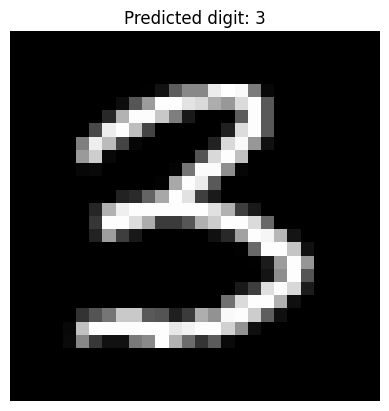

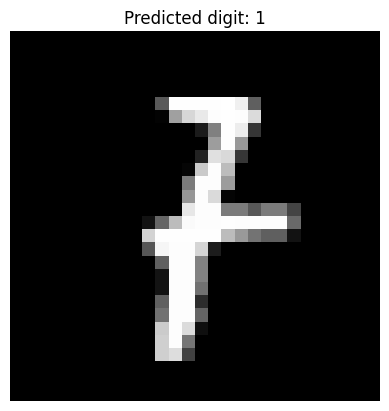

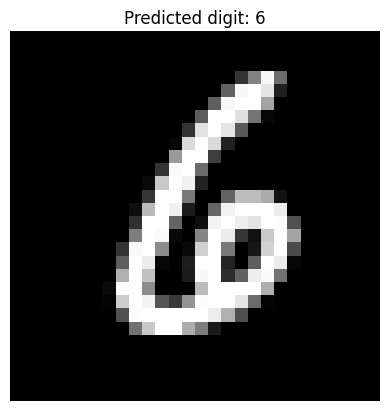

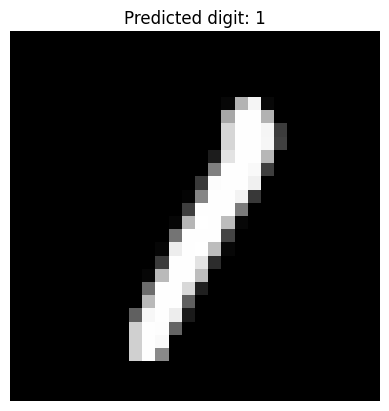

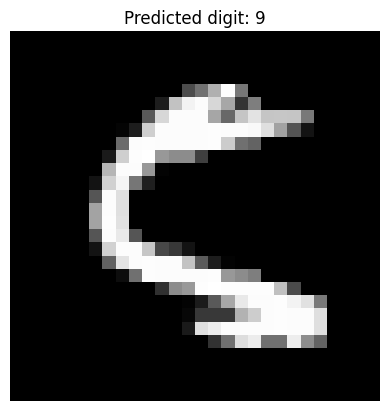

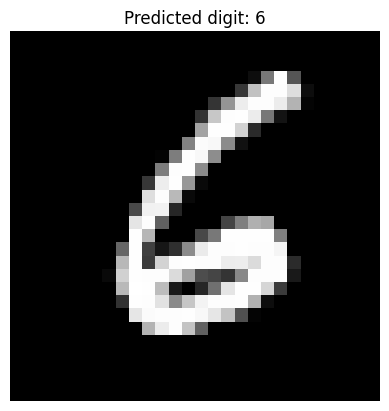

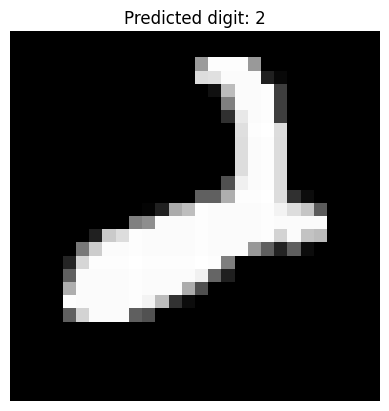

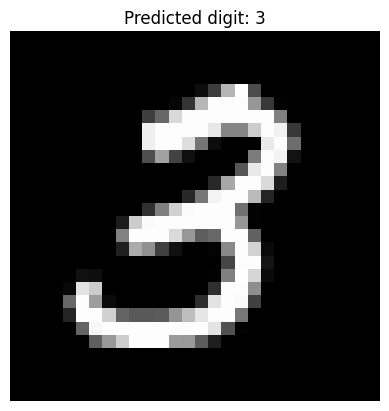

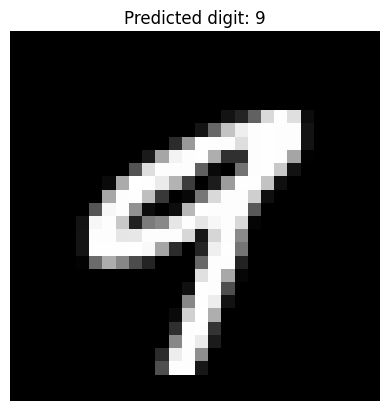

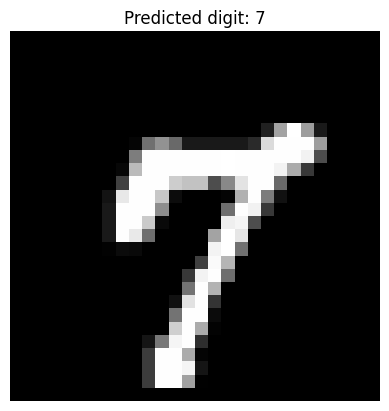

In [7]:
def get_digits_data():

    train_dataset = []

    train = pd.read_csv("../data/digits/train.csv", header=0, nrows=5000)

    for index in train.index:
        input_values = [
            float(val) / 255.0 for val in train.loc[index].drop("label").values
        ]
        train_dataset.append(
            {
                "input": input_values,
                "output": get_onehot_digit(int(train.loc[index]["label"])),
            }
        )

    random.seed(1)
    random.shuffle(train_dataset)
    return train_dataset[:800], train_dataset[800:1000]

train_dataset, test_dataset = get_digits_data()

layers = [
    FullyConnected(256, LeakyRelu()),
    FullyConnected(128, LeakyRelu()),
    FullyConnected(64, LeakyRelu()),
    FullyConnected(10, Linear()),
]
nn = NeuralNetwork(
    Input(784),
    layers,
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossEntropy(),
    metric=AccuracyOneHot(),
    convert_prediction="argmax",
    on_cuda=False
)

start_time = time.time()

epochs = 15
history = nn.fit(train_dataset, test_dataset, epochs=epochs, batch_size=1, verbose=True)

print("--- %s seconds ---" % (time.time() - start_time))

prediction = nn.predict(test_dataset)

for index, predicted_digit in enumerate(prediction[:10]):
    plot_digit(test_dataset[index]['input'], get_digit(predicted_digit))

In [8]:
def plot_digit_cnn(image, digit):
    image = torch.tensor(image).numpy()
    plt.figure()
    plt.title(f"Predicted digit: {digit}")
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.show()

    return

In [9]:
def get_digits_data_cnn():

    train_dataset = []

    train = pd.read_csv("../data/digits/train.csv", header=0, nrows=5000)

    for index in train.index:
        input_values = [
            float(val) / 255.0 for val in train.loc[index].drop("label").values
        ]
        train_dataset.append(
            {
                "input": [torch.tensor(input_values).reshape(28, 28).tolist()],
                "output": get_onehot_digit(int(train.loc[index]["label"])),
            }
        )

    # print(train_dataset[:2])
    # import sys
    # sys.exit(1)
    
    random.seed(1)
    random.shuffle(train_dataset)
    return train_dataset[:800], train_dataset[800:1000]

In [10]:
train_data, test_data = get_digits_data_cnn()

layers = [
    Convolutional(LeakyRelu(), filters_num=4, kernel_size=3),
    Convolutional(LeakyRelu(), filters_num=8, kernel_size=3),
    Convolutional(LeakyRelu(), filters_num=16, kernel_size=3),
    Flatten(),
    FullyConnected(128, LeakyRelu()),
    FullyConnected(10, Linear())
]
nn = NeuralNetwork(
    Input3D((1, 28, 28)),
    layers,
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossEntropy(),
    metric=AccuracyOneHot(),
    convert_prediction='argmax',
    on_cuda=False
)

#plot_digit(train_data[0]['input'][0])

start_time = time.time()
epochs = 15
nn.fit(train_data, test_data, epochs=epochs, batch_size=1, verbose=True)
print('exec time: ', time.time() - start_time)

prediction = nn.predict(test_data)

for index, predicted_digit in enumerate(prediction[:10]):
    plot_digit_cnn(test_data[index]['input'][0], get_digit(predicted_digit))

Epoch: 1/15, train loss: 1.9339, train Accuracy: 0.7113, test loss: 1.7944, test Accuracy: 0.87, epoch time: 267.695s
Epoch: 2/15, train loss: 1.6755, train Accuracy: 0.9337, test loss: 1.748, test Accuracy: 0.89, epoch time: 266.964s
Epoch: 3/15, train loss: 1.5813, train Accuracy: 0.9812, test loss: 1.625, test Accuracy: 0.89, epoch time: 403.62s


KeyboardInterrupt: 

In [ ]:
# train_data = [
#     {
#         'input': [0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0],
#         'output': [1.0, 0.0]
#     },
#     {
#         'input': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
#         'output': [0.0, 1.0]
#     }    
# ]

# test_data = [
#     {
#         'input': [1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0],
#         'output': [1.0, 0.0]
#     },
#     {
#         'input': [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
#         'output': [0.0, 1.0]
#     }    
# ]

# layers = [
#     FullyConnected(25, LeakyRelu()),
#     FullyConnected(10, LeakyRelu()),
#     FullyConnected(2, Linear())
# ]
# nn = NeuralNetwork(
#     Input(25),
#     layers,
#     optimizer=SGD(),
#     loss=CategoricalCrossEntropy(),
#     metric=AccuracyOneHot(),
#     convert_prediction='argmax'
# )

# start_time = time.time()
# epochs = 200
# nn.fit(train_data, test_data, epochs=epochs, verbose=True)
# print('exec time: ', time.time() - start_time)

# print('test_222')